In [1]:
%matplotlib inline

import math
import datetime

import numpy as np

from pandas import DataFrame
from pandas import concat

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

debug = True

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cuda = False #FIXME: re-install tensorflow and CUDA to get it to work again
debug = True
N = 5
one_hot_size = 32

In [3]:
#MATLAB colors
colors = [[0, 0.4470, 0.7410],
          [0.8500, 0.3250, 0.0980],
          [0.9290, 0.6940, 0.1250],
          [0.4940, 0.1840, 0.5560],
          [0.4660, 0.6740, 0.1880],
          [0.3010, 0.7450, 0.9330],
          [0.6350, 0.0780, 0.1840]];

colormap = plt.get_cmap('rainbow')

def getColor(num, brightness=1):
    col = colors[num]
    return [col[0]*brightness, col[1]*brightness, col[2]*brightness]

## Encoding/decoding ThingML messages into 1-D tensors

### 1-hot encoding

ThingML messages are encoded into 1D tensors, using a simple 1-hot encoding:
- first, we encode the message type. Here, indices 0..13 are used to encode messages `clear`..`updateIA`. In principle, there will only be a single `1.0` value in the range 0..13, indicating that a message is either a `clear` message or (XOR) a `setColor` message, etc. However, the prediction will likely produce result like `clear:0.87`, `setColor:0.14`, etc. We decode the message type by taking the highest score.
- second, we encode the parameters of the message e.g. indices 14..16 are used to encode `r`, `g` and `b`. Note that different messages can have the same parameters (or a common subset), and in this case, indices for parameters will be reused. For example, indices 14..16 are used by `setColor` and `setBGColor`. A parameter is predicted present if it scores `>= 0.5`. 

The encoding of training, validation and test data is based by parsing lines starting with `!` and `@` in the logs.

### Example

A message `setColor(r=107, b=94, b=174)` send by the `BreakoutGame` thing is serialized as `[3,107,94,174]` on the network. 

In the log files, this is represented by `!3,107,94,174,` followed by `@BreakoutGameNodeJS@setColor,r,g,b,`. See `def logToData(filename)`

The same message is 1-hot encoded as `[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 1.0, 1.0, 0, 0, ..., 0]`. It is decoded as `[setColor, r, g, b]`.

Assume a prediction producing the following 1D tensor:

`predict = [0.22, 0.87, 0.17, 0.32, 0.12, 0.33, 0.22, 0.13, 0.17, 0.16, 0.32, 0.33, 0.37, 0.18, 0.67, 0.44, 0.55, <0.5, <0.5, ..., <0.5]`

This will be decoded as `[setColor, r, b]`. Indeed:
- predict[1] > predict[*n*] for *n* in 0..13, and predict[1] encodes for `setColor`
- predict[14] = 0.67 >= 0.5, and predict[14] encodes for parameter `r`
- predict[15] = 0.44 < 0.5,  and predict[15] encodes for parameter `g`. Parameter `g` is thus not deemed to be present.
- predict[16] = 0.55 >= 0.5, and predict[16] encodes for parameter `b`

In [4]:
# 1-hot encoding of the ThingML messages between controller/AI and game logic
def encode(msg):
    encoded = [0]*one_hot_size
    valid = False
    for x in msg:
        # Encode message
        if x.startswith('clear'):
            encoded[0] = 1
            valid = True
        elif x.startswith('setColor'):
            encoded[1] = 1
            valid = True
        elif x.startswith('setBGColor'):
            encoded[2] = 1
            valid = True
        elif x.startswith('drawRect'):
            encoded[3] = 1
            valid = True
        elif x.startswith('fillRect'):
            encoded[4] = 1
            valid = True
        elif x.startswith('drawInteger'):
            encoded[5] = 1
            valid = True
        elif x.startswith('drawThingML'):
            encoded[6] = 1
            valid = True
        elif x.startswith('create'):
            encoded[7] = 1
            valid = True
        elif x.startswith('destroy'):
            encoded[8] = 1
            valid = True
        elif x.startswith('update'):
            encoded[9] = 1
            valid = True
        elif x.startswith('displayReady'):
            encoded[10] = 1
            valid = True
        elif x.startswith('velocity'):
            encoded[11] = 1
            valid = True
        elif x.startswith('position'):
            encoded[12] = 1
            valid = True
        elif x.startswith('updateIA'):
            encoded[13] = 1
            valid = True
        else: # Encode params                       
            if x == 'r':
                encoded[14] = 1
            elif x == 'g':
                encoded[15] = 1
            elif x == 'b':
                encoded[16] = 1  
            elif x == 'x':
                encoded[17] = 1   
            elif x == 'y':
                encoded[18] = 1
            elif x == 'width':
                encoded[19] = 1
            elif x == 'height':
                encoded[20] = 1  
            elif x == 'v':
                encoded[21] = 1   
            elif x == 'digits':
                encoded[22] = 1                
            elif x == 'scale':
                encoded[23] = 1  
            elif x == 'xsize':
                encoded[24] = 1   
            elif x == 'ysize':
                encoded[25] = 1   
            elif x == 'dx':
                encoded[26] = 1                
            elif x == 'dy':
                encoded[27] = 1  
            elif x == 'padx':
                encoded[28] = 1   
            elif x == 'pady':
                encoded[29] = 1                   
            elif x == 'ballx':
                encoded[30] = 1   
            elif x == 'bally':
                encoded[31] = 1
    if valid:
        #print(encoded)
        return encoded
    else:
        return None


def decode(encoded):
    message = []
    
    # decode message
    max_id = -1
    max_v = 0
    for i in range(0, 13):
        if encoded[i] > max_v:
            max_v = encoded[i]
            max_id = i
    if max_id == 0:
        message.append('clear')
    elif max_id == 1:
        message.append('setColor')
    elif max_id == 2:
        message.append('setBGColor')
    elif max_id == 3:
        message.append('drawRect')
    elif max_id == 4:
        message.append('fillRect')
    elif max_id == 5:
        message.append('drawInteger')
    elif max_id == 6:
        message.append('drawThingML')
    elif max_id == 7:
        message.append('create')
    elif max_id == 8:
        message.append('destroy')
    elif max_id == 9:
        message.append('update')
    elif max_id == 10:
        message.append('displayReady')
    elif max_id == 11:
        message.append('velocity')
    elif max_id == 12:
        message.append('position')
    elif max_id == 13:
        message.append('updateIA')
    else:
        message.append('???')
            
    # decode params
    if encoded[14] >= 0.5:
        message.append('r')
    if encoded[15] >= 0.5:
        message.append('g')
    if encoded[16] >= 0.5:
        message.append('b')
    if encoded[17] >= 0.5:
        message.append('x') 
    if encoded[18] >= 0.5:
        message.append('y') 
    if encoded[19] >= 0.5:
        message.append('width') 
    if encoded[20] >= 0.5:
        message.append('height') 
    if encoded[21] >= 0.5:
        message.append('v')   
    if encoded[22] >= 0.5:
        message.append('digits')                 
    if encoded[23] >= 0.5:
        message.append('scale')                 
    if encoded[24] >= 0.5:
        message.append('xsize')                 
    if encoded[25] >= 0.5:
        message.append('ysize')                 
    if encoded[26] >= 0.5:
        message.append('dx')                 
    if encoded[27] >= 0.5:
        message.append('dy')                 
    if encoded[28] >= 0.5:
        message.append('padx')   
    if encoded[29] >= 0.5:
        message.append('pady')              
    if encoded[30] >= 0.5:
        message.append('ballx')   
    if encoded[31] >= 0.5:
        message.append('bally')   
                        
    return message
        

def logToData(filename):
    file = open(filename)
    while True:
        line = file.readline()      
        if not line:
            break        
        if line.startswith('!'):
            raw_bytes = list(line[1:].strip().split(',')[:-1])
            raw_bytes_float = []
            for b in raw_bytes:
                raw_bytes_float.append(int(b)/255)
            while True:
                line = file.readline()      
                if not line:
                    break        
                elif line.startswith('@'):
                    encoded = encode(line.split('@')[2].split(','))
                    if encoded != None:
                        yield raw_bytes_float, encoded
                    break;    

In [5]:
def loadAllData(base, N):
    maxbytelen = 0
    logs = []
    for i in range(0,N):
        log = list(logToData(base+str(i)+'.log'))
        logs.append(log)
        for msg in log:
            length = len(msg[0])
            maxbytelen = max(maxbytelen, length)
    X = []
    Y = []
    for log in logs:
        x = np.zeros((len(log),maxbytelen))
        #x = np.zeros((len(log),one_hot_size))
        y = np.zeros((len(log),one_hot_size))
        for i, msg in enumerate(log):
            x[i,0:len(msg[0])] = msg[0]
            y[i,:] = msg[1]
        X.append(x)
        Y.append(y)
    return X, Y, maxbytelen

In [6]:
base_dir = '../../../../../experiments1-logs/thingml-bytes-logs/nodejs/'

base_X, base_Y, base_maxbytelen = loadAllData(base_dir+'base/nodejs', N)
static_X, static_Y, static_maxbytelen = loadAllData(base_dir+'static/nodejs', N)
runtime_X, runtime_Y, runtime_maxbytelen = loadAllData(base_dir+'dynamic/nodejs', N)

In [7]:
print(str(base_maxbytelen) + ', ' + str(static_maxbytelen) + ', ' + str(runtime_maxbytelen))

9, 9, 10


In [8]:
def split(data, train_ratio = 0.60):
    train = []
    test = []
    for log in data:
        length = log.shape[0]
        train_size = int(length * train_ratio)
        train.append(log[0:train_size,:])
        test.append(log[train_size:,:])
    return train, test

base_X_train, base_X_test = split(base_X)
base_Y_train, base_Y_test = split(base_Y)

static_X_train, static_X_test = split(static_X)
static_Y_train, static_Y_test = split(static_Y)

runtime_X_train, runtime_X_test = split(runtime_X)
runtime_Y_train, runtime_Y_test = split(runtime_Y)

In [9]:
number_of_msgs = 10 

def series_to_supervised(all_data, maxbytelen):
    results = []
    for j in range(0,N):
        result = []
        data = all_data[j].flatten()
        for i in range(0,int(len(data)/(number_of_msgs*maxbytelen))):
            time_window = data[i*maxbytelen:number_of_msgs*maxbytelen+i*maxbytelen]
            result.append(time_window)
        results.append(result)
    np_results = np.array(results)
    np_results = np.reshape(np_results, (np_results.shape[0], np_results.shape[1], number_of_msgs, int(np_results.shape[2]/number_of_msgs)))
    return np_results

base_X_train_supervised = series_to_supervised(base_X_train, base_maxbytelen)
static_X_train_supervised = series_to_supervised(static_X_train, static_maxbytelen)
runtime_X_train_supervised = series_to_supervised(runtime_X_train, runtime_maxbytelen)

base_Y_train_supervised = series_to_supervised(base_Y_train, one_hot_size)
static_Y_train_supervised = series_to_supervised(static_Y_train, one_hot_size)
runtime_Y_train_supervised = series_to_supervised(runtime_Y_train, one_hot_size)

base_X_test_supervised = series_to_supervised(base_X_test, base_maxbytelen)
static_X_test_supervised = series_to_supervised(static_X_test, static_maxbytelen)
runtime_X_test_supervised = series_to_supervised(runtime_X_test, runtime_maxbytelen)

base_Y_test_supervised = series_to_supervised(base_Y_test, one_hot_size)
static_Y_test_supervised = series_to_supervised(static_Y_test, one_hot_size)
runtime_Y_test_supervised = series_to_supervised(runtime_Y_test, one_hot_size)

if debug:
    print(base_X_train_supervised.shape, ' ', base_Y_train_supervised.shape)
    print(static_X_train_supervised.shape, ' ', static_Y_train_supervised.shape)
    print(runtime_X_train_supervised.shape, ' ', runtime_Y_train_supervised.shape)

    print(base_X_test_supervised.shape, ' ', base_Y_test_supervised.shape)
    print(static_X_test_supervised.shape, ' ', static_Y_test_supervised.shape)
    print(runtime_X_test_supervised.shape, ' ', runtime_Y_test_supervised.shape)

(5, 827, 10, 9)   (5, 827, 10, 32)
(5, 1655, 10, 9)   (5, 1655, 10, 32)
(5, 1655, 10, 10)   (5, 1655, 10, 32)
(5, 551, 10, 9)   (5, 551, 10, 32)
(5, 1103, 10, 9)   (5, 1103, 10, 32)
(5, 1103, 10, 10)   (5, 1103, 10, 32)


In [10]:
def keras_model(x, y):    
    model = keras.Sequential()
    #model.add(keras.layers.Dropout(0.2, input_shape=(x,)))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(100, activation='relu', input_dim=x)))
    if cuda:
        model.add(keras.layers.CuDNNLSTM(50, return_sequences=True))
    else:
        model.add(keras.layers.LSTM(50, return_sequences=True))
    #model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(25, activation='relu')))
    #model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(y, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'binary_accuracy'])    
    return model

def train_and_save(model, train_X, train_Y, test_X, test_Y, mode, xp, save=False):        
    earlystop_loss = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=6, verbose=1, mode='min')
    earlystop_val_loss = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=6, verbose=1, mode='min')
    earlystop_acc = keras.callbacks.EarlyStopping(monitor='acc', min_delta=0.001, patience=6, verbose=1, mode='max')
    earlystop_val_acc = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.001, patience=6, verbose=1, mode='max')
    
    tensorboard_log = keras.callbacks.TensorBoard(log_dir=base_dir+'/tensorboard/'+mode+'/'+str(xp))
    
    callbacks_list = [tensorboard_log, earlystop_loss, earlystop_val_loss, earlystop_acc, earlystop_val_acc]  
        
    model.fit(train_X, train_Y, batch_size=1, epochs=20, validation_split=0.2, verbose=1, callbacks=callbacks_list)

    if save:
        model.save_weights(base_dir + mode + str(xp) + '_class_lstm.h5')
#         try:
#             keras.utils.plot_model(model, to_file=base_dir + mode + str(xp) + '_class_lstm.png')
#         except:
#             print('Cound not save image for Keras model at ', to_file=base_dir + mode + str(xp)+'_class_lstm.png')
            
#     if debug:
#         result = model.evaluate(test_X, test_Y)
#         print(result)
    return model

In [11]:
def predict(model, test_X, test_Y):
    predictions = model.predict(test_X)    
    errors = 0
    for i in range(0, predictions.shape[0]):
        for j in range(0, predictions.shape[2], one_hot_size):
            predicted = np.array(encode(decode(predictions[i][0][j:j+one_hot_size]))).astype(int)
            truth = test_Y[i][0][j:j+one_hot_size].astype(int)
            errs = np.sum(np.abs(predicted - truth))/len(truth)
            if debug and errs > 0:
                errors = errors + errs
                print('Predicting ', decode(predicted), '. Truth is ', decode(truth))    
    error_ratio = round((errors/(test_Y.shape[0]*test_Y.shape[2])*100),2)

    return error_ratio

In [12]:
def xp(train_X, train_Y, test_X, test_Y, mode):
    print('xp ', mode)
    results = []
    for i in range(0, N): 
        print('  #', i)
        print('----')
        model = keras_model(train_X[i].shape[2], train_Y[i].shape[2])
        train_start = datetime.datetime.now()
        model = train_and_save(model, train_X[i], train_Y[i], test_X[i], test_Y[i], mode, i, save=True)
        model.summary()
        train_stop = predict_start = datetime.datetime.now()
        error_ratio = predict(model, test_X[i], test_Y[i])
        predict_stop = datetime.datetime.now()
        train_duration = train_stop - train_start
        predict_duration = predict_stop - predict_start
        print(error_ratio, '% error')
        print('training duration = ', train_duration)
        print('prediction duration = ', predict_duration)
        results.append((error_ratio, train_duration, predict_duration))
    return results

In [13]:
base_results = xp(base_X_train_supervised, base_Y_train_supervised, base_X_test_supervised, base_Y_test_supervised, 'base')
static_results = xp(static_X_train_supervised, static_Y_train_supervised, static_X_test_supervised, static_Y_test_supervised, 'static')
runtime_results = xp(runtime_X_train_supervised, runtime_Y_train_supervised, runtime_X_test_supervised, runtime_Y_test_supervised, 'runtime')

xp  base
  # 0
----
Train on 661 samples, validate on 166 samples
Epoch 1/20
661/661 [==============================] - 22s 34ms/step - loss: 0.1600 - acc: 0.9380 - binary_accuracy: 0.9380 - val_loss: 0.0325 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 2/20
661/661 [==============================] - 22s 33ms/step - loss: 0.0350 - acc: 0.9899 - binary_accuracy: 0.9899 - val_loss: 0.0163 - val_acc: 0.9975 - val_binary_accuracy: 0.9975
Epoch 3/20
661/661 [==============================] - 21s 31ms/step - loss: 0.0257 - acc: 0.9923 - binary_accuracy: 0.9923 - val_loss: 0.0107 - val_acc: 0.9984 - val_binary_accuracy: 0.9984
Epoch 4/20
661/661 [==============================] - 21s 31ms/step - loss: 0.0196 - acc: 0.9939 - binary_accuracy: 0.9939 - val_loss: 0.0080 - val_acc: 0.9985 - val_binary_accuracy: 0.9985
Epoch 5/20
661/661 [==============================] - 21s 31ms/step - loss: 0.0149 - acc: 0.9958 - binary_accuracy: 0.9958 - val_loss: 0.0057 - val_acc: 0.9985 - val_binary_a

Predicting  ['fillRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['setColor', 'x', 'y'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['setColor', 'x', 'y'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['fillRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['setColor', 'x', 'y'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['setColor', 'x', 'y'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['fillRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['setColor', 'x', 'y'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['setColor', 'x', 'y'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['fillRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['setColor', 'x', 'y'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['setColo

Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['fillRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['fillRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['fillRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['fillRec

Predicting  ['drawRect', 'x', 'y'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['drawRect', 'x', 'y', 'height'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['fillRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['drawRect', 'x', 'y', 'height'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['drawRect', 'x', 'y', 'height'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['fillRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['drawRect', 'x', 'y', 'height'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  [

Train on 661 samples, validate on 166 samples
Epoch 1/20
661/661 [==============================] - 22s 33ms/step - loss: 0.1467 - acc: 0.9393 - binary_accuracy: 0.9393 - val_loss: 0.0261 - val_acc: 0.9935 - val_binary_accuracy: 0.9935
Epoch 2/20
661/661 [==============================] - 20s 31ms/step - loss: 0.0310 - acc: 0.9903 - binary_accuracy: 0.9903 - val_loss: 0.0125 - val_acc: 0.9984 - val_binary_accuracy: 0.9984
Epoch 3/20
661/661 [==============================] - 20s 30ms/step - loss: 0.0220 - acc: 0.9928 - binary_accuracy: 0.9928 - val_loss: 0.0089 - val_acc: 0.9984 - val_binary_accuracy: 0.9984
Epoch 4/20
661/661 [==============================] - 20s 31ms/step - loss: 0.0162 - acc: 0.9949 - binary_accuracy: 0.9949 - val_loss: 0.0053 - val_acc: 0.9984 - val_binary_accuracy: 0.9984
Epoch 5/20
661/661 [==============================] - 20s 31ms/step - loss: 0.0117 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0041 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoc

Predicting  ['position', 'x', 'y', 'width', 'height'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['fillRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['position', 'x', 'y', 'width', 'height'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['position', 'x', 'y', 'width', 'height'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['fillRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['position', 'x', 'y', 'width', 'height'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['fillRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['fillRect', 'x', '

Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['position', 'r', 'g', 'b', 'y'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['position', 'r', 'g', 'b', 'y'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['fillRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['position', 'r', 'g', 'b', 'y'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['position', 'r', 'g', 'b', 'y'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['fillRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['drawRect', 'x', 'y', 'width', 'height'] . Truth is  ['fillRect', 'x', 'y', 'width', 'hei

Epoch 1/20
1324/1324 [==============================] - 43s 33ms/step - loss: 0.1573 - acc: 0.9349 - binary_accuracy: 0.9349 - val_loss: 0.0731 - val_acc: 0.9747 - val_binary_accuracy: 0.9747
Epoch 2/20
1324/1324 [==============================] - 42s 32ms/step - loss: 0.0540 - acc: 0.9826 - binary_accuracy: 0.9826 - val_loss: 0.0315 - val_acc: 0.9913 - val_binary_accuracy: 0.9913
Epoch 3/20
1324/1324 [==============================] - 42s 32ms/step - loss: 0.0321 - acc: 0.9912 - binary_accuracy: 0.9912 - val_loss: 0.0200 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 4/20
1324/1324 [==============================] - 42s 32ms/step - loss: 0.0207 - acc: 0.9944 - binary_accuracy: 0.9944 - val_loss: 0.0127 - val_acc: 0.9966 - val_binary_accuracy: 0.9966
Epoch 5/20
1324/1324 [==============================] - 42s 32ms/step - loss: 0.0132 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0078 - val_acc: 0.9979 - val_binary_accuracy: 0.9979
Epoch 6/20
1324/1324 [==================

1324/1324 [==============================] - 42s 32ms/step - loss: 0.0041 - acc: 0.9988 - binary_accuracy: 0.9988 - val_loss: 0.0029 - val_acc: 0.9993 - val_binary_accuracy: 0.9993
Epoch 11/20
1324/1324 [==============================] - 41s 31ms/step - loss: 0.0038 - acc: 0.9990 - binary_accuracy: 0.9990 - val_loss: 0.0017 - val_acc: 0.9996 - val_binary_accuracy: 0.9996
Epoch 12/20
1324/1324 [==============================] - 42s 32ms/step - loss: 0.0032 - acc: 0.9992 - binary_accuracy: 0.9992 - val_loss: 0.0016 - val_acc: 0.9994 - val_binary_accuracy: 0.9994
Epoch 13/20
1324/1324 [==============================] - 42s 32ms/step - loss: 0.0028 - acc: 0.9993 - binary_accuracy: 0.9993 - val_loss: 0.0014 - val_acc: 0.9998 - val_binary_accuracy: 0.9998
Epoch 14/20
1324/1324 [==============================] - 42s 31ms/step - loss: 0.0027 - acc: 0.9993 - binary_accuracy: 0.9993 - val_loss: 0.0015 - val_acc: 0.9996 - val_binary_accuracy: 0.9996
Epoch 00014: early stopping
___________________

  # 2
----
Train on 1324 samples, validate on 331 samples
Epoch 1/20
1324/1324 [==============================] - 43s 32ms/step - loss: 0.1579 - acc: 0.9346 - binary_accuracy: 0.9346 - val_loss: 0.0680 - val_acc: 0.9773 - val_binary_accuracy: 0.9773
Epoch 2/20
1324/1324 [==============================] - 43s 32ms/step - loss: 0.0625 - acc: 0.9783 - binary_accuracy: 0.9783 - val_loss: 0.0402 - val_acc: 0.9882 - val_binary_accuracy: 0.9882
Epoch 3/20
1324/1324 [==============================] - 41s 31ms/step - loss: 0.0398 - acc: 0.9869 - binary_accuracy: 0.9869 - val_loss: 0.0289 - val_acc: 0.9902 - val_binary_accuracy: 0.9902
Epoch 4/20
1324/1324 [==============================] - 41s 31ms/step - loss: 0.0270 - acc: 0.9917 - binary_accuracy: 0.9917 - val_loss: 0.0203 - val_acc: 0.9933 - val_binary_accuracy: 0.9933
Epoch 5/20
1324/1324 [==============================] - 41s 31ms/step - loss: 0.0201 - acc: 0.9938 - binary_accuracy: 0.9938 - val_loss: 0.0179 - val_acc: 0.9933 - val_binary

Predicting  ['fillRect'] . Truth is  ['position', 'x']
Predicting  ['fillRect', 'r', 'g', 'y', 'height'] . Truth is  ['fillRect', 'x', 'y', 'height']
Predicting  ['fillRect', 'r', 'g', 'height'] . Truth is  ['fillRect', 'x', 'y', 'height']
Predicting  ['fillRect', 'r', 'g', 'height'] . Truth is  ['fillRect', 'x', 'y', 'height']
Predicting  ['position'] . Truth is  ['update']
Predicting  ['setColor', 'b'] . Truth is  ['update']
Predicting  ['setColor', 'b'] . Truth is  ['position', 'y']
Predicting  ['fillRect'] . Truth is  ['position', 'x']
Predicting  ['fillRect', 'y', 'height'] . Truth is  ['fillRect', 'x', 'y', 'height']
Predicting  ['fillRect', 'r', 'g', 'y', 'height'] . Truth is  ['fillRect', 'x', 'y', 'height']
Predicting  ['position'] . Truth is  ['update']
Predicting  ['setColor', 'b'] . Truth is  ['update']
Predicting  ['update'] . Truth is  ['position', 'y']
Predicting  ['fillRect'] . Truth is  ['position', 'x']
Predicting  ['setColor', 'r', 'g', 'height'] . Truth is  ['fillRe

Epoch 6/20
1324/1324 [==============================] - 42s 32ms/step - loss: 0.0117 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0084 - val_acc: 0.9970 - val_binary_accuracy: 0.9970
Epoch 7/20
1324/1324 [==============================] - 42s 31ms/step - loss: 0.0104 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0077 - val_acc: 0.9967 - val_binary_accuracy: 0.9967
Epoch 8/20
1324/1324 [==============================] - 43s 33ms/step - loss: 0.0087 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0056 - val_acc: 0.9980 - val_binary_accuracy: 0.9980
Epoch 9/20
1324/1324 [==============================] - 42s 32ms/step - loss: 0.0080 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0054 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 10/20
1324/1324 [==============================] - 41s 31ms/step - loss: 0.0070 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0059 - val_acc: 0.9978 - val_binary_accuracy: 0.9978
Epoch 11/20
1324/1324 [================

Predicting  ['position'] . Truth is  ['position', 'y']
Predicting  ['setColor', 'g', 'b'] . Truth is  ['position', 'x']
0.04 % error
training duration =  0:11:19.711659
prediction duration =  0:00:00.984068
  # 4
----
Train on 1324 samples, validate on 331 samples
Epoch 1/20
1324/1324 [==============================] - 43s 33ms/step - loss: 0.1539 - acc: 0.9395 - binary_accuracy: 0.9395 - val_loss: 0.0794 - val_acc: 0.9692 - val_binary_accuracy: 0.9692
Epoch 2/20
1324/1324 [==============================] - 42s 32ms/step - loss: 0.0500 - acc: 0.9845 - binary_accuracy: 0.9845 - val_loss: 0.0332 - val_acc: 0.9895 - val_binary_accuracy: 0.9895
Epoch 3/20
1324/1324 [==============================] - 43s 32ms/step - loss: 0.0256 - acc: 0.9932 - binary_accuracy: 0.9932 - val_loss: 0.0160 - val_acc: 0.9953 - val_binary_accuracy: 0.9953
Epoch 4/20
1324/1324 [==============================] - 41s 31ms/step - loss: 0.0187 - acc: 0.9948 - binary_accuracy: 0.9948 - val_loss: 0.0143 - val_acc: 0.99

Predicting  ['fillRect'] . Truth is  ['update', 'padx']
Predicting  ['setColor', 'r'] . Truth is  ['update']
Predicting  ['fillRect', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['update'] . Truth is  ['position']
Predicting  ['setBGColor'] . Truth is  ['update', 'padx']
Predicting  ['setColor'] . Truth is  ['update']
Predicting  ['fillRect', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['update'] . Truth is  ['position']
Predicting  ['fillRect'] . Truth is  ['fillRect', 'x']
Predicting  ['setBGColor'] . Truth is  ['update', 'padx']
Predicting  ['setColor', 'r'] . Truth is  ['update']
Predicting  ['fillRect', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['update'] . Truth is  ['position']
Predicting  ['fillRect'] . Truth is  ['fillRect', 'x']
Predicting  ['fillRect', 'x'] . Truth is  ['update', 'padx']
Predicting  ['update', 'x'] . Truth is  ['update']
Predicting  ['fillRect', 'y', 'width', 'height'] . Truth

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_20 (TimeDis multiple                  1100      
_________________________________________________________________
lstm_10 (LSTM)               multiple                  30200     
_________________________________________________________________
time_distributed_21 (TimeDis multiple                  1275      
_________________________________________________________________
dense_32 (Dense)             multiple                  832       
Total params: 33,407
Trainable params: 33,407
Non-trainable params: 0
_________________________________________________________________
Predicting  ['fillRect', 'height'] . Truth is  ['fillRect', 'x', 'width', 'height']
Predicting  ['position'] . Truth is  ['position', 'y']
Predicting  ['drawRect', 'x', 'width'] . Truth is  ['position', 'x']
Predicting  ['setColor', 'b'] . Truth is  ['fillRect', 'x', 'y

Predicting  ['setColor', 'b'] . Truth is  ['fillRect', 'x', 'y']
Predicting  ['fillRect'] . Truth is  ['update']
Predicting  ['drawRect', 'g', 'x'] . Truth is  ['position', 'x', 'y']
Predicting  ['fillRect', 'height'] . Truth is  ['fillRect', 'x', 'width', 'height']
Predicting  ['setColor', 'b'] . Truth is  ['fillRect', 'x', 'y']
Predicting  ['fillRect', 'b', 'x', 'y'] . Truth is  ['fillRect', 'x', 'y']
Predicting  ['fillRect', 'b', 'x', 'y'] . Truth is  ['fillRect', 'x', 'y']
Predicting  ['position'] . Truth is  ['position', 'y']
Predicting  ['drawRect', 'g', 'x', 'width'] . Truth is  ['position', 'x']
Predicting  ['fillRect', 'b', 'x', 'y'] . Truth is  ['fillRect', 'x', 'y']
Predicting  ['setColor', 'g'] . Truth is  ['setBGColor', 'g']
Predicting  ['setColor', 'g', 'b'] . Truth is  ['setBGColor', 'r', 'b']
Predicting  ['fillRect', 'x', 'y'] . Truth is  ['drawInteger', 'x', 'y', 'digits']
Predicting  ['drawRect', 'x', 'width'] . Truth is  ['drawInteger', 'v', 'scale']
Predicting  ['se

Epoch 1/20
1324/1324 [==============================] - 44s 33ms/step - loss: 0.1819 - acc: 0.9265 - binary_accuracy: 0.9265 - val_loss: 0.1283 - val_acc: 0.9516 - val_binary_accuracy: 0.9516
Epoch 2/20
1324/1324 [==============================] - 44s 33ms/step - loss: 0.1010 - acc: 0.9604 - binary_accuracy: 0.9604 - val_loss: 0.0681 - val_acc: 0.9721 - val_binary_accuracy: 0.9721
Epoch 3/20
1324/1324 [==============================] - 43s 32ms/step - loss: 0.0673 - acc: 0.9740 - binary_accuracy: 0.9740 - val_loss: 0.0482 - val_acc: 0.9846 - val_binary_accuracy: 0.9846
Epoch 4/20
1324/1324 [==============================] - 43s 33ms/step - loss: 0.0549 - acc: 0.9800 - binary_accuracy: 0.9800 - val_loss: 0.0418 - val_acc: 0.9889 - val_binary_accuracy: 0.9889
Epoch 5/20
1324/1324 [==============================] - 43s 32ms/step - loss: 0.0477 - acc: 0.9830 - binary_accuracy: 0.9830 - val_loss: 0.0345 - val_acc: 0.9905 - val_binary_accuracy: 0.9905
Epoch 6/20
1324/1324 [==================

Predicting  ['fillRect', 'x', 'y', 'height'] . Truth is  ['setBGColor', 'g']
Predicting  ['setBGColor', 'x'] . Truth is  ['setBGColor', 'r', 'b']
Predicting  ['fillRect'] . Truth is  ['drawInteger', 'y', 'scale']
Predicting  ['fillRect', 'width'] . Truth is  ['drawInteger', 'x', 'v', 'digits']
Predicting  ['fillRect', 'x', 'y', 'width', 'height'] . Truth is  ['fillRect', 'x', 'y', 'height']
Predicting  ['setColor', 'g'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['setColor'] . Truth is  ['fillRect']
Predicting  ['setColor'] . Truth is  ['fillRect']
Predicting  ['position', 'x', 'y'] . Truth is  ['fillRect', 'x', 'y', 'width', 'height']
Predicting  ['fillRect', 'x'] . Truth is  ['update', 'ballx']
Predicting  ['setColor'] . Truth is  ['update']
Predicting  ['fillRect', 'x', 'y', 'width', 'height'] . Truth is  ['position', 'x', 'y']
Predicting  ['fillRect', 'x', 'y', 'width', 'height'] . Truth is  ['fillRect', 'x', 'y', 'height']
Predicting  ['setColor', 'g'] . Tru

Epoch 1/20
1324/1324 [==============================] - 43s 33ms/step - loss: 0.1671 - acc: 0.9372 - binary_accuracy: 0.9372 - val_loss: 0.0966 - val_acc: 0.9643 - val_binary_accuracy: 0.9643
Epoch 2/20
1324/1324 [==============================] - 43s 33ms/step - loss: 0.0711 - acc: 0.9759 - binary_accuracy: 0.9759 - val_loss: 0.0475 - val_acc: 0.9862 - val_binary_accuracy: 0.9862
Epoch 3/20
1324/1324 [==============================] - 43s 32ms/step - loss: 0.0467 - acc: 0.9844 - binary_accuracy: 0.9844 - val_loss: 0.0364 - val_acc: 0.9874 - val_binary_accuracy: 0.9874
Epoch 4/20
1324/1324 [==============================] - 42s 32ms/step - loss: 0.0357 - acc: 0.9881 - binary_accuracy: 0.9881 - val_loss: 0.0242 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 5/20
1324/1324 [==============================] - 42s 32ms/step - loss: 0.0287 - acc: 0.9904 - binary_accuracy: 0.9904 - val_loss: 0.0174 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 6/20
1324/1324 [==================

Predicting  ['setColor', 'b'] . Truth is  ['update']
Predicting  ['update', 'width'] . Truth is  ['position', 'x']
Predicting  ['fillRect', 'width'] . Truth is  ['fillRect', 'x', 'width']
Predicting  ['position'] . Truth is  ['update', 'padx']
Predicting  ['fillRect', 'y', 'height'] . Truth is  ['position', 'x']
Predicting  ['fillRect', 'width'] . Truth is  ['fillRect', 'x', 'width']
Predicting  ['drawRect', 'x', 'width'] . Truth is  ['fillRect', 'x', 'width']
Predicting  ['update'] . Truth is  ['update', 'padx']
Predicting  ['setColor', 'b'] . Truth is  ['update']
Predicting  ['update', 'width'] . Truth is  ['position', 'x']
Predicting  ['fillRect', 'width'] . Truth is  ['fillRect', 'x', 'width']
Predicting  ['drawRect', 'x', 'width'] . Truth is  ['fillRect', 'x', 'width']
Predicting  ['setColor', 'b'] . Truth is  ['update']
Predicting  ['update', 'width'] . Truth is  ['position', 'x']
Predicting  ['fillRect', 'width'] . Truth is  ['fillRect', 'x', 'width']
Predicting  ['fillRect', 'w

Epoch 1/20
1324/1324 [==============================] - 44s 33ms/step - loss: 0.1938 - acc: 0.9217 - binary_accuracy: 0.9217 - val_loss: 0.1111 - val_acc: 0.9565 - val_binary_accuracy: 0.9565
Epoch 2/20
1324/1324 [==============================] - 42s 31ms/step - loss: 0.1041 - acc: 0.9612 - binary_accuracy: 0.9612 - val_loss: 0.0779 - val_acc: 0.9713 - val_binary_accuracy: 0.9713
Epoch 3/20
1324/1324 [==============================] - 41s 31ms/step - loss: 0.0791 - acc: 0.9706 - binary_accuracy: 0.9706 - val_loss: 0.0523 - val_acc: 0.9801 - val_binary_accuracy: 0.9801
Epoch 4/20
1324/1324 [==============================] - 41s 31ms/step - loss: 0.0606 - acc: 0.9785 - binary_accuracy: 0.9785 - val_loss: 0.0389 - val_acc: 0.9890 - val_binary_accuracy: 0.9890
Epoch 5/20
1324/1324 [==============================] - 42s 32ms/step - loss: 0.0448 - acc: 0.9864 - binary_accuracy: 0.9864 - val_loss: 0.0284 - val_acc: 0.9934 - val_binary_accuracy: 0.9934
Epoch 6/20
1324/1324 [==================

Predicting  ['setColor'] . Truth is  ['update']
Predicting  ['update', 'x', 'y'] . Truth is  ['position', 'x', 'y']
Predicting  ['position'] . Truth is  ['update']
Predicting  ['update', 'pady', 'ballx', 'bally'] . Truth is  ['update', 'padx', 'pady', 'ballx', 'bally']
Predicting  ['update', 'x', 'y'] . Truth is  ['position', 'x', 'y']
Predicting  ['update', 'x', 'y', 'padx'] . Truth is  ['update', 'padx']
Predicting  ['update', 'x', 'y'] . Truth is  ['position', 'x', 'y']
Predicting  ['update', 'x', 'padx'] . Truth is  ['update', 'padx']
Predicting  ['setColor'] . Truth is  ['update']
Predicting  ['fillRect', 'width'] . Truth is  ['update']
Predicting  ['update', 'x', 'y'] . Truth is  ['position', 'x', 'y']
Predicting  ['setColor'] . Truth is  ['fillRect', 'width']
Predicting  ['setColor'] . Truth is  ['fillRect', 'width']
Predicting  ['update', 'pady', 'ballx', 'bally'] . Truth is  ['position', 'x', 'y']
0.03 % error
training duration =  0:12:03.530705
prediction duration =  0:00:01.

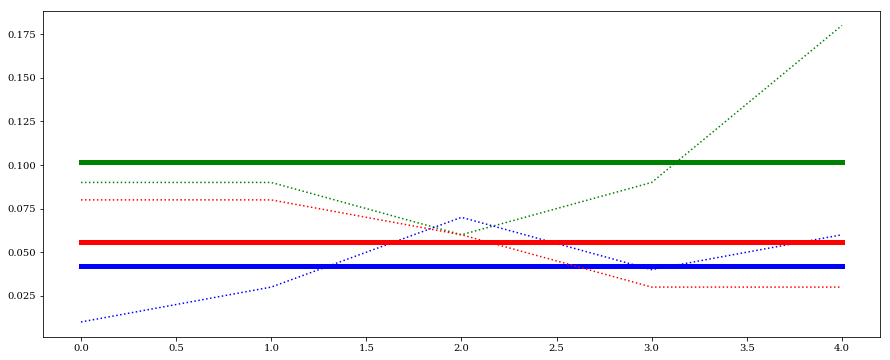

In [16]:
def get_errors(results, errors):
    for e,_,_ in results:
        errors.append(e)        

        
base_errors = []
get_errors(base_results, base_errors)

static_errors = []
get_errors(static_results, static_errors)

runtime_errors = []
get_errors(runtime_results, runtime_errors)


plt.figure(4, figsize=(15,6))
plt.plot(base_errors, color='green', ls='dotted')
mean = np.mean(base_errors)
plt.plot([0, len(base_errors)-1], [mean, mean], linewidth=5, color='green')
plt.plot(static_errors, color='blue', ls='dotted')
mean = np.mean(static_errors)
plt.plot([0, len(static_errors)-1], [mean, mean], linewidth=5, color='blue')
plt.plot(runtime_errors, color='red', ls='dotted')
mean = np.mean(runtime_errors)
plt.plot([0, len(runtime_errors)-1], [mean, mean], linewidth=5, color='red')
plt.show()

In [17]:
def xp2(train_X, train_Y, test_X, test_Y, mode):
    results = []
    for i in range(0,N):
        model = keras.models.load_model(base_dir + mode + str(i) + '_class_lstm.h5')
#         model = keras_model(train_X[i].shape[2], train_Y[i].shape[2])
        train_start = datetime.datetime.now()
        model = train_and_save(model, train_X[i], train_Y[i], test_X[i], test_Y[i], mode, i, save=True)
        model.summary()
        train_stop = datetime.datetime.now()
        train_duration = train_stop - train_start
        for j in range(0,N):
            print('using model ', str(i), ' on data coming from ', str(j))
            print('-------------------------')
            predict_start = datetime.datetime.now()
            error_ratio = predict(model, test_X[j], test_Y[j])
            predict_stop = datetime.datetime.now()
            predict_duration = predict_stop - predict_start
            print(error_ratio, '% error')
            print('prediction duration = ', predict_duration)
            results.append((error_ratio, train_duration, predict_duration))
    return results

base_results_2 = xp2(base_X_train_supervised, base_Y_train_supervised, base_X_test_supervised, base_Y_test_supervised, 'base')
static_results_2 = xp2(static_X_train_supervised, static_Y_train_supervised, static_X_test_supervised, static_Y_test_supervised, 'static')
runtime_results_2 = xp2(runtime_X_train_supervised, runtime_Y_train_supervised, runtime_X_test_supervised, runtime_Y_test_supervised, 'runtime')

ValueError: No model found in config file.